In [5]:
import h5py as h5

datadir = '../../dataset/optimization'
figuredir = '../../figure/intensity/optimization'

os.makedirs(figuredir, exist_ok=True)

In [34]:
runs = {}

for filename in os.listdir(datadir):
    key = filename.split('.')[0]
    
    if key not in runs:
        runs[key] = {}
    run = runs[key]
    
    with h5.File(os.path.join(datadir, filename), 'r') as file:
        for k in list(file.keys()):
            if '@' in k:
                k = k.split('-')
                A = int(k[0].split('@')[-1])
                i = int(k[1].split('@')[-1])
                 
                if A not in run:
                    run[A] = []
                run[A].append(i)
            
            else:
                A = int(k.split('amplitude')[1])

                for k in file[k].keys():                    
                    if '@' in k:
                        i = int(k.split('@')[-1])
                    else:
                        i = int(k.split('iteration')[1])


                    if A not in run:
                        run[A] = []
                    run[A].append(i)
                    
runs

{'1200mV-32': {0: [0, 63],
  1: [0, 1, 19, 32, 37, 4, 5],
  10: [0, 1, 100, 15, 4],
  11: [0, 137, 158, 17, 201, 202, 217, 278, 352, 481, 8],
  12: [0, 1, 14, 2, 418],
  13: [0,
   130,
   165,
   17,
   192,
   2,
   237,
   238,
   351,
   355,
   395,
   407,
   411,
   427,
   479,
   55,
   6,
   9],
  14: [0, 1, 355, 7],
  15: [0, 1, 157, 203, 238, 282, 292, 446, 491, 50],
  16: [0, 1, 86],
  17: [0, 100, 152, 165, 22, 240, 251, 284, 335, 375, 382, 426, 485, 487, 51],
  18: [0, 10, 26],
  19: [0, 1, 2, 20, 5, 57, 89],
  2: [0, 1, 163, 46, 52, 60],
  20: [0, 162, 2, 3],
  21: [0, 1, 156, 3, 6],
  22: [0, 1, 113, 357, 64],
  23: [0, 216, 27, 28, 9],
  24: [0, 1, 159, 2],
  25: [0, 1, 12, 136, 14, 17, 232, 326, 368],
  26: [0, 1, 15, 18, 184, 193, 24, 277, 47],
  27: [0, 1, 350, 4, 42, 5, 53],
  28: [0, 162, 166, 18, 185, 213, 233, 242, 333, 414, 56, 63, 71],
  29: [0, 1, 2, 4, 415],
  3: [0, 28, 36, 65, 75, 8],
  30: [0,
   103,
   170,
   176,
   198,
   27,
   271,
   272,
   282

In [65]:
def read(filename, dataset):
    df = pd.read_hdf(os.path.join(datadir, filename), dataset)
    df['frequency'] = 80e6 + 40e6 * df.time / df.time.max()
    
    return df

def read_final(filename):
    key = filename.split('.')[0]

    An = max(runs[key].keys())
    n = max(runs[key][An])
    
    try:
        return read(filename, f'amplitude{An}/iteration{n}')
    except KeyError:
        try:
            return read(filename, f'amplitude@{An}-iteration@{n}')
        except KeyError:
            return read(filename, f'amplitude{An}/iteration@{n}')

In [68]:
final32_1200 = read_final('1200mV-32.h5')
final32_1000 = read_final('1000mV-32.h5')
final32_0800 = read_final('800mV-32.h5')

final16_1200 = read_final('1200mV-16.h5')
final16_1000 = read_final('1000mV-16.h5')
final16_0800 = read_final('800mV-16.h5')

final8_1200 = read_final('1200mV-8.h5')
final8_1000 = read_final('1000mV-8.h5')
final8_0800 = read_final('800mV-8.h5')

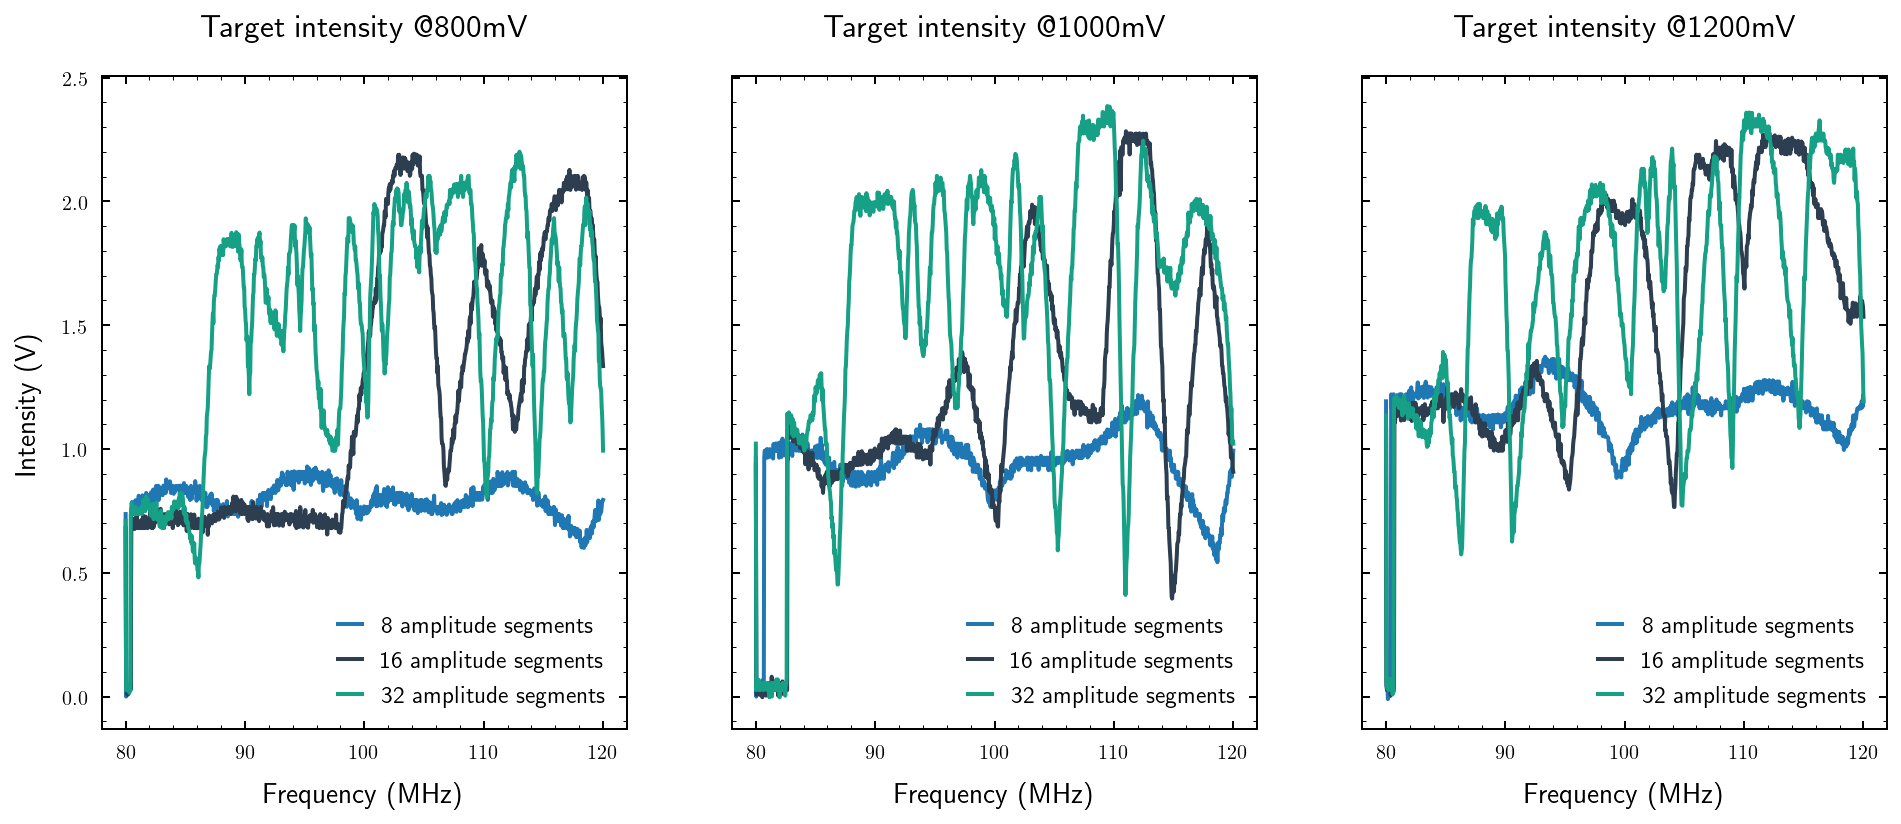

In [82]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 6), sharey=True)

axes[0].set_title('Target intensity @800mV')
axes[0].plot(final8_0800.frequency / 1e6, final8_0800.voltage, label='8 amplitude segments')
axes[0].plot(final16_0800.frequency / 1e6, final16_0800.voltage, label='16 amplitude segments', color='#2c3e50')
axes[0].plot(final32_0800.frequency / 1e6, final32_0800.voltage, label='32 amplitude segments', color='#16a085')
axes[0].set_ylabel('Intensity (V)')
axes[0].legend()

axes[1].set_title('Target intensity @1000mV')
axes[1].plot(final8_1000.frequency / 1e6, final8_1000.voltage, label='8 amplitude segments')
axes[1].plot(final16_1000.frequency / 1e6, final16_1000.voltage, label='16 amplitude segments', color='#2c3e50')
axes[1].plot(final32_1000.frequency / 1e6, final32_1000.voltage, label='32 amplitude segments', color='#16a085')
axes[1].legend()

axes[2].set_title('Target intensity @1200mV')
axes[2].plot(final8_1200.frequency / 1e6, final8_1200.voltage, label='8 amplitude segments')
axes[2].plot(final16_1200.frequency / 1e6, final16_1200.voltage, label='16 amplitude segments', color='#2c3e50')
axes[2].plot(final32_1200.frequency / 1e6, final32_1200.voltage, label='32 amplitude segments', color='#16a085')
axes[2].legend()

for axis in axes:
    axis.set_xlabel('Frequency (MHz)')
#    axis.set_ylabel('Intensity (V)')

plt.savefig(os.path.join(figuredir, 'target-intensities.pdf'))
plt.show()

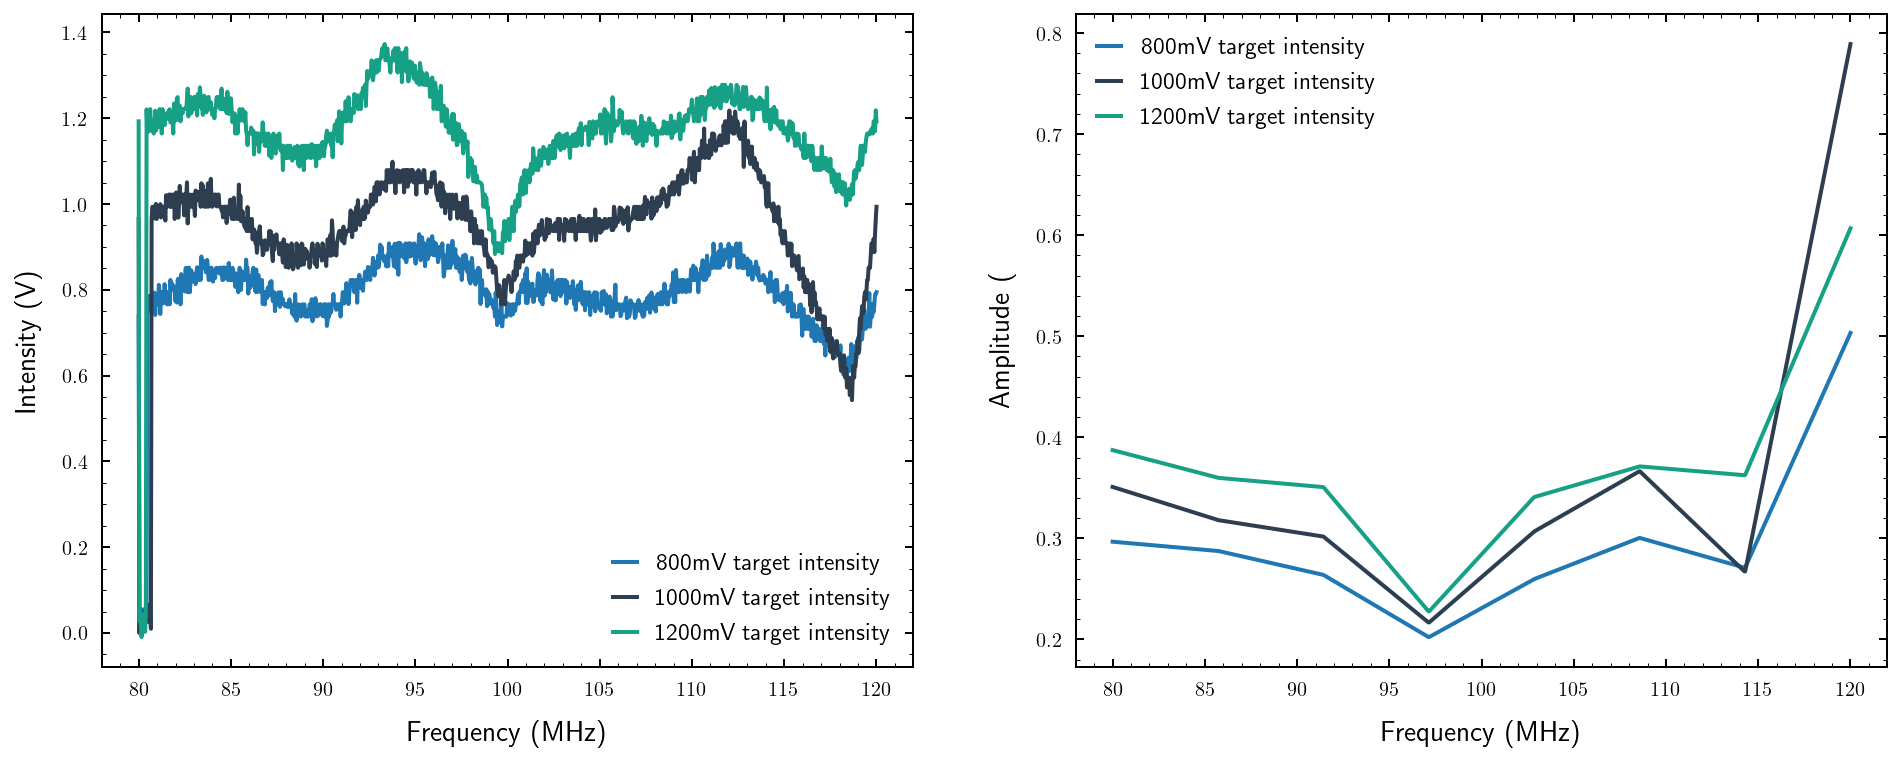

In [100]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 6), sharex=True)

axes[0].plot(final8_0800.frequency / 1e6, final8_0800.voltage, label='800mV target intensity')
axes[0].plot(final8_1000.frequency / 1e6, final8_1000.voltage, label='1000mV target intensity', color='#2c3e50')
axes[0].plot(final8_1200.frequency / 1e6, final8_1200.voltage, label='1200mV target intensity', color='#16a085')
axes[0].set_ylabel('Intensity (V)')
axes[0].set_xlabel('Frequency (MHz)')
axes[0].legend()

axes[1].plot(final8_0800.frequency / 1e6, final8_0800.amplitude, label='800mV target intensity')
axes[1].plot(final8_1000.frequency / 1e6, final8_1000.amplitude, label='1000mV target intensity', color='#2c3e50')
axes[1].plot(final8_1200.frequency / 1e6, final8_1200.amplitude, label='1200mV target intensity', color='#16a085')
axes[1].set_ylabel('Amplitude (%)')
axes[1].set_xlabel('Frequency (MHz)')
axes[1].legend()


#for axis in axes:
#    axis.set_xlabel('Frequency (MHz)')
#    axis.set_ylabel('Intensity (V)')

#plt.savefig(os.path.join(figuredir, 'target-intensities.pdf'))
plt.show()

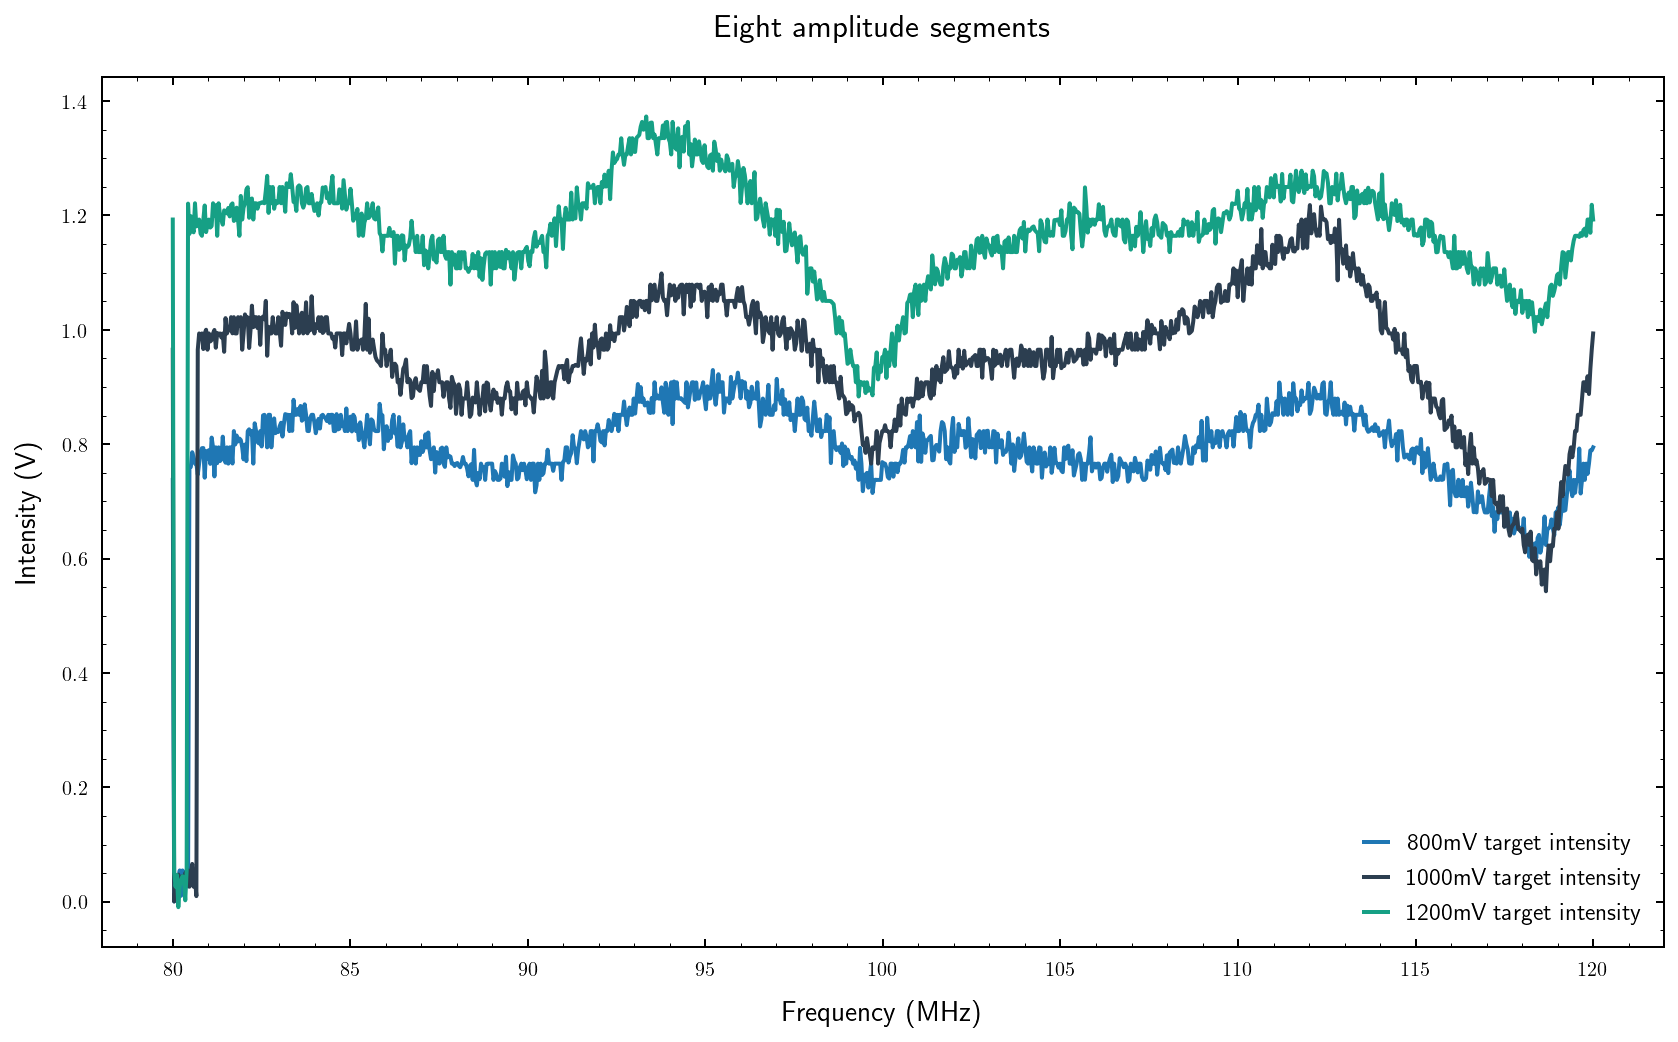

In [81]:
plt.figure(figsize=(14, 8))
plt.title('Eight amplitude segments')
plt.plot(final8_0800.frequency / 1e6, final8_0800.voltage, label='800mV target intensity')
plt.plot(final8_1000.frequency / 1e6, final8_1000.voltage, label='1000mV target intensity', color='#2c3e50')
plt.plot(final8_1200.frequency / 1e6, final8_1200.voltage, label='1200mV target intensity', color='#16a085')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Intensity (V)')
plt.legend()
plt.savefig(os.path.join(figuredir, 'amplitude-segments.pdf'))
plt.show()

In [84]:
runs['800mV-8']

{0: [0, 1, 14, 3, 87, 96],
 1: [0, 1, 2, 221, 395, 7, 87],
 2: [0, 1, 18, 225, 28, 7, 96],
 3: [0, 1, 151, 44, 5],
 4: [0, 1, 124, 15, 16, 2, 3, 39, 4],
 5: [0, 10, 108, 2, 257, 27, 4],
 6: [0, 15, 18, 19, 2, 3, 36, 4, 99],
 7: [0, 12, 13, 3]}

In [96]:
A0 = []

for n in runs['800mV-8'][0]:
    A0.append((n, read('800mV-8.h5', f'amplitude0/iteration{n}')))

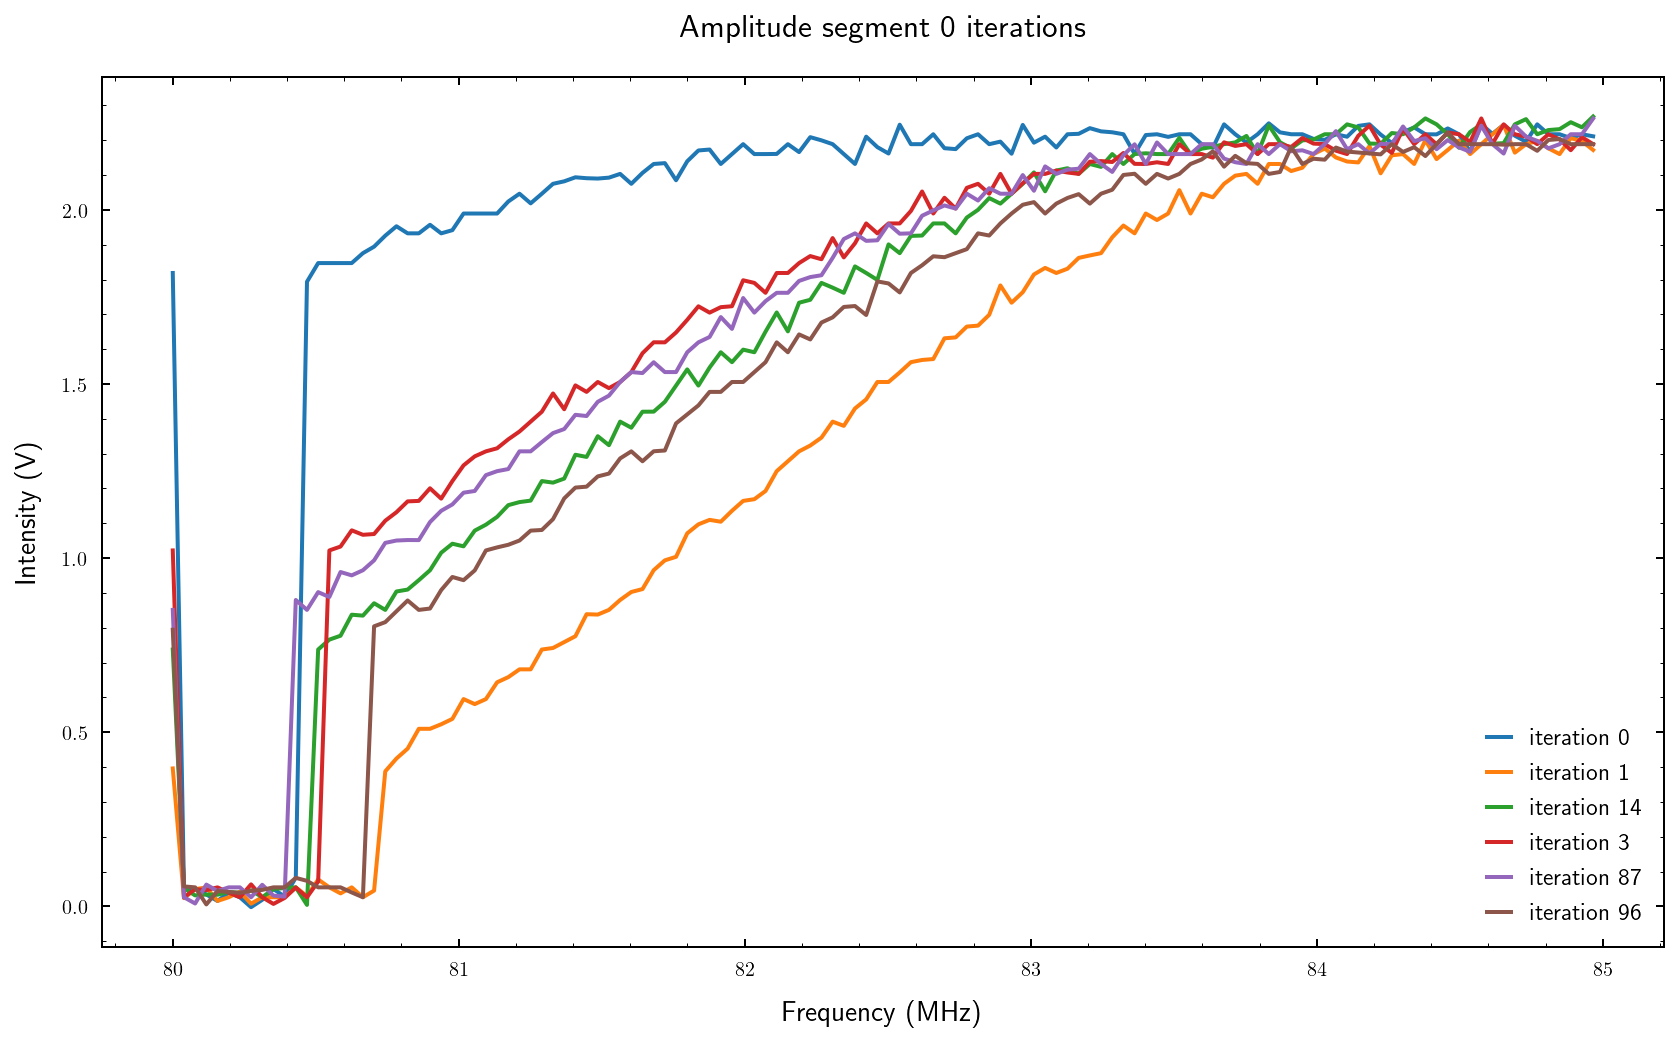

In [102]:
plt.figure(figsize=(14, 8))
plt.title('Amplitude segment 0 iterations')

for i, df in A0:
    df = df[(df.frequency > 80e6) & (df.frequency < 85e6)]
    plt.plot(df.frequency / 1e6, df.voltage, label=f'iteration {i}')

plt.xlabel('Frequency (MHz)')
plt.ylabel('Intensity (V)')
plt.legend()
plt.savefig(os.path.join(figuredir, 'amplitude-segments.pdf'))
plt.show()

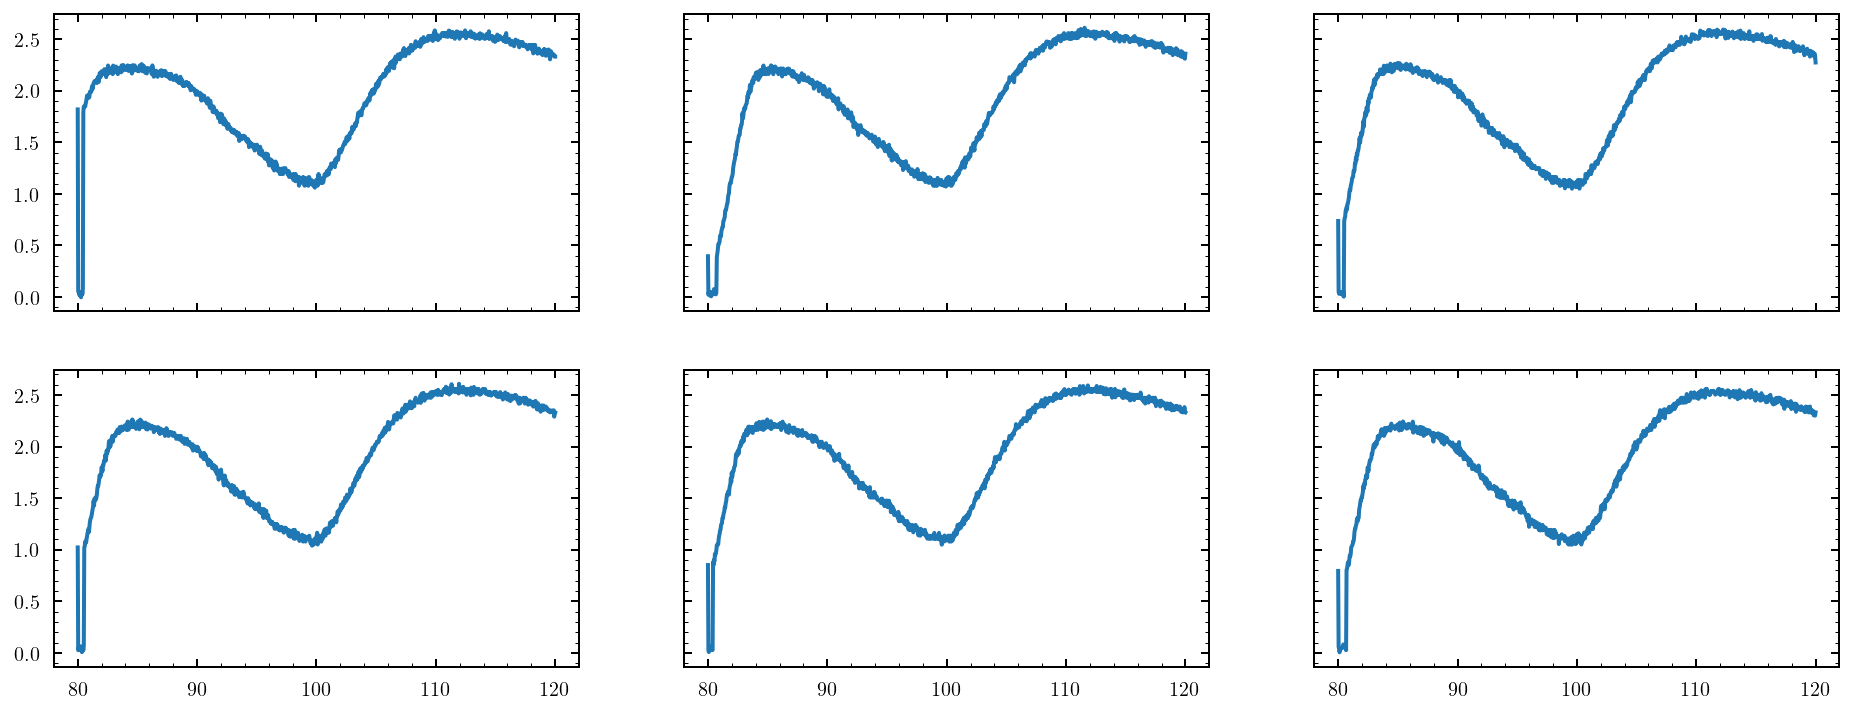

In [95]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 6), sharey=True, sharex=True)

for i, axis in enumerate(axes.flatten()):
    df = A0[i]

    axis.plot(df.frequency / 1e6, df.voltage, label='8 amplitude segments')

#plt.savefig(os.path.join(figuredir, 'target-intensities.pdf'))
plt.show()